In [2]:
# Diabetes Prediction Model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve
import joblib

In [ ]:
# Step 2: Load the Dataset
df = pd.read_csv('D:\Daibetes\diabetes_prediction_dataset.csv')
df.head()

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\dell\AppData\Local\Temp\ipykernel_11880\2788564678.py:2: SyntaxWarning: invalid escape sequence '\D'
  df = pd.read_csv('D:\Daibetes\diabetes_prediction_dataset.csv')


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


   gender  smoking_history
0       0                4
1       0                0
2       1                4
3       0                1
4       1                1


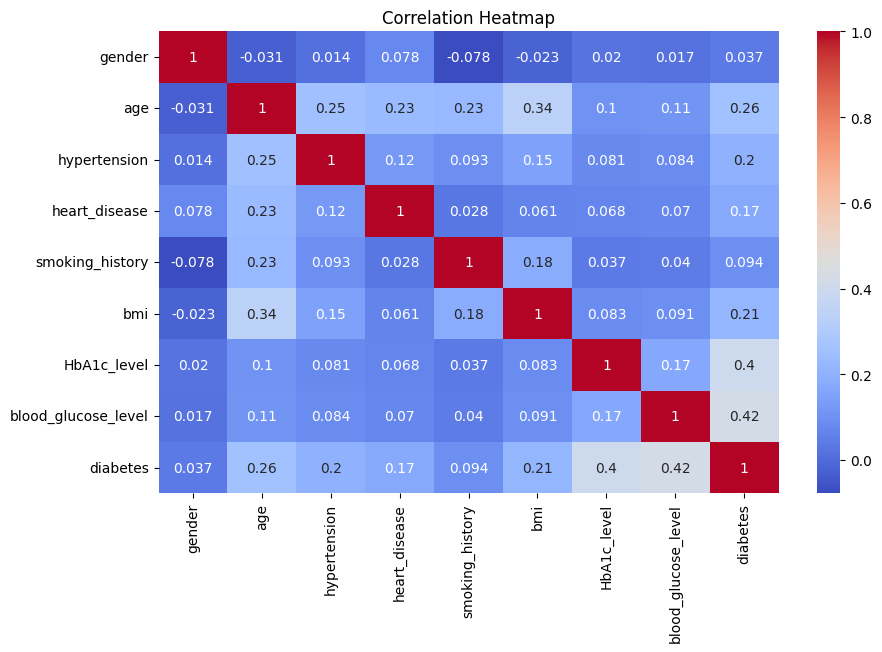

In [4]:
# Step 3: Exploratory Data Analysis (EDA)

# Encode categorical columns using LabelEncoder for simplicity since they are binary
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Encoding 'gender' and 'smoking' (converting 'Male'/'Female' to 0/1 and 'Yes'/'No' to 0/1)
df['gender'] = label_encoder.fit_transform(df['gender'])
df['smoking_history'] = label_encoder.fit_transform(df['smoking_history'])

# Check if encoding was successful
print(df[['gender', 'smoking_history']].head())

# Correlation Heatmap to understand feature relationships
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [5]:
# Step 4: Data Preprocessing

# Categorical and numerical columns separation
categorical_cols = ['gender', 'smoking_history']  # Assuming these are the only categorical features
numerical_cols = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Preprocessing for numerical data: Imputation (median) + Scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data: Imputation (most frequent) + One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))  # Avoid dummy variable trap
])

# Combining preprocessing steps for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [6]:
# Step 5: Splitting Data into Training and Testing sets

X = df.drop(columns=['diabetes'])  # Features
y = df['diabetes']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
# Step 6: Model Training using Pipelines

# Pipeline for Logistic Regression
log_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42))
])

# Pipeline for Random Forest Classifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

In [8]:

# Step 7: Hyperparameter Tuning and Cross-Validation

# Random Forest Hyperparameters tuning using GridSearchCV
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(rf_pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
best_rf_model = grid_search_rf.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Random Forest: {'model__max_depth': 20, 'model__min_samples_split': 10, 'model__n_estimators': 200}


Logistic Regression Model Performance:
[[18122   178]
 [  613  1087]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.86      0.64      0.73      1700

    accuracy                           0.96     20000
   macro avg       0.91      0.81      0.86     20000
weighted avg       0.96      0.96      0.96     20000

ROC-AUC Score: 0.9624980874316941
Accuracy: 0.96045
Random Forest Model Performance:
[[18285    15]
 [  539  1161]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       0.99      0.68      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

ROC-AUC Score: 0.9732674220507875
Accuracy: 0.9723


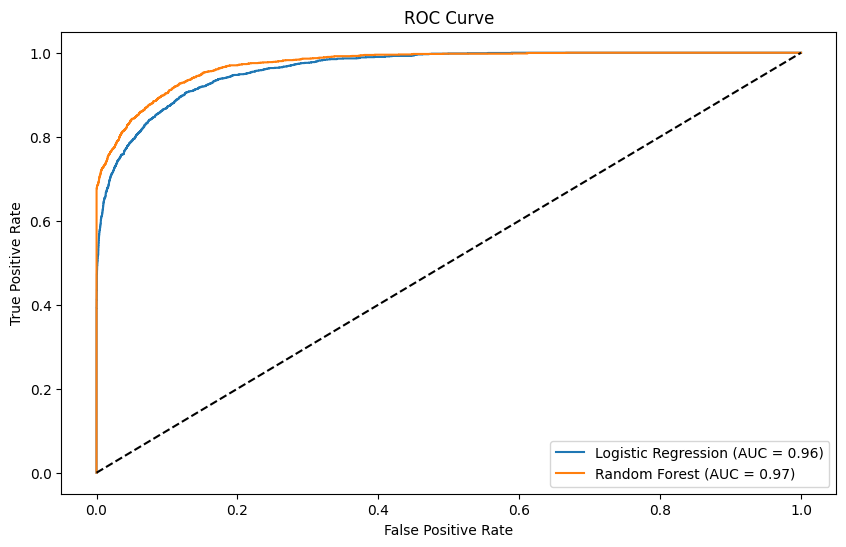

In [9]:
# Step 8: Model Evaluation

# Logistic Regression Evaluation
log_pipeline.fit(X_train, y_train)
y_pred_log = log_pipeline.predict(X_test)

print("Logistic Regression Model Performance:")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print(f"ROC-AUC Score: {roc_auc_score(y_test, log_pipeline.predict_proba(X_test)[:, 1])}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log)}")

# Random Forest Evaluation (with tuned hyperparameters)
y_pred_rf = best_rf_model.predict(X_test)

print("Random Forest Model Performance:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")

# ROC Curve for both models
y_pred_log_proba = log_pipeline.predict_proba(X_test)[:, 1]
y_pred_rf_proba = best_rf_model.predict_proba(X_test)[:, 1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_log_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_log_proba)))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_rf_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [10]:
# Step 9: Save the Best Model

# Saving the Random Forest Model (Assuming it performs better)
joblib.dump(best_rf_model, 'diabetes_prediction_model.pkl')
print("Random Forest Model saved successfully!")

# Step 10: Load the Model for Future Predictions
# To load the model, you can use:
# loaded_model = joblib.load('diabetes_prediction_model.pkl')
# predictions = loaded_model.predict(new_data)


Random Forest Model saved successfully!


In [11]:
# Save your trained model (assuming it's the Random Forest model)
joblib.dump(best_rf_model, 'diabetes_prediction_model.pkl')


['diabetes_prediction_model.pkl']

In [12]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
pip install pickle5

     ---------------------------------------- 0.0/132.1 kB ? eta -:--:--
     --- ------------------------------------ 10.2/132.1 kB ? eta -:--:--
     ----------------------------------- -- 122.9/132.1 kB 1.8 MB/s eta 0:00:01
     -------------------------------------- 132.1/132.1 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pickle5
Failed to build pickle5
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\pickle.py -> build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\pickletools.py -> build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\__init__.py -> build\lib.win-amd64-cpython-312\pickle5
      creating build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\pickletester.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\test_pickle.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\test_picklebuffer.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\__init__.py -> build\lib.win-amd64-cpython-312\pickle5\test
      running build_ext
      building 'pickle5._pickle' extension
      erro